# DỊCH MÁY ANH–PHÁP / VỚI MÔ HÌNH ENCODER–DECODER LSTM


## 1. Cài đặt các thư viện




In [17]:
print("Installing dependencies...")
print("="*80)

!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!pip install torchtext


try:
    import spacy
    spacy.load("en_core_web_sm")
    print("✓ en_core_web_sm already available")
except Exception:
    try:
        !python -m spacy download en_core_web_sm -q
        print("✓ en_core_web_sm downloaded via spacy")
    except Exception:
        !pip -q install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
        print("✓ en_core_web_sm installed via direct wheel")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import spacy
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Setup completed!")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 146.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 137.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✓ en_core_web_sm already available

✅ Setup completed!
🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 Memory: 15.83 GB


## 2. Tải MULTI30K Dataset

In [48]:
print("\n" + "="*80)
print("TẢI MULTI30K (EN–FR)")
print("="*80)

import requests
import gzip
import io

BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"

FILES_GZ = {
    "train.en": "train.en.gz",
    "train.fr": "train.fr.gz",
    "val.en":   "val.en.gz",
    "val.fr":   "val.fr.gz",
    "test.en":  "test_2016_flickr.en.gz",
    "test.fr":  "test_2016_flickr.fr.gz",
}

def _download_gz_lines(url: str, timeout: int = 60) -> list[str]:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as f:
        return f.read().splitlines()

def download_multi30k():
    data = {}
    print("Downloading .gz files:")

    for key, fname in FILES_GZ.items():
        url = BASE_URL + fname
        try:
            lines = _download_gz_lines(url)
            data[key] = lines
            print(f"  ✓ {fname}: {len(lines)}")
        except Exception as e:
            print(f"  ✗ {fname}: {type(e).__name__}")

    n_train = len(data.get("train.en", []))
    n_val   = len(data.get("val.en", []))
    n_test  = len(data.get("test.en", []))

    print("\n📊 Dataset Statistics:")
    print(f"  • Train: {n_train:,}")
    print(f"  • Val:   {n_val:,}")
    print(f"  • Test:  {n_test:,}")
    return data

raw_data = download_multi30k()


TẢI MULTI30K (EN–FR)
  ✓ train.en.gz: 29000
  ✓ train.fr.gz: 29000
  ✓ val.en.gz: 1014
  ✓ val.fr.gz: 1014
  ✓ test_2016_flickr.en.gz: 1000
  ✓ test_2016_flickr.fr.gz: 1000

📊 Dataset Statistics:
  • Train: 29,000
  • Val:   1,014
  • Test:  1,000


## 3. TOKENIZATION VỚI SPACY

In [49]:
print("\n" + "="*80)
print("TOKENIZE với SPACY")
print("="*80)

import spacy
from tqdm import tqdm

print("Loading spaCy models...")
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")
print("  ✓ en_core_web_sm")
print("  ✓ fr_core_news_sm")

def preprocess_text(text: str) -> str:
    return " ".join(text.split()).lower()

def tokenize_en(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

print("\nTokenizing datasets...")
train_en = [tokenize_en(s) for s in tqdm(raw_data["train.en"], desc="Train EN")]
train_fr = [tokenize_fr(s) for s in tqdm(raw_data["train.fr"], desc="Train FR")]
val_en   = [tokenize_en(s) for s in tqdm(raw_data["val.en"],   desc="Val EN")]
val_fr   = [tokenize_fr(s) for s in tqdm(raw_data["val.fr"],   desc="Val FR")]
test_en  = [tokenize_en(s) for s in tqdm(raw_data["test.en"],  desc="Test EN")]
test_fr  = [tokenize_fr(s) for s in tqdm(raw_data["test.fr"],  desc="Test FR")]

print("\n📌 Tokenization example:")
print("EN raw :", raw_data["train.en"][0])
print("EN tok :", train_en[0])
print("FR raw :", raw_data["train.fr"][0])
print("FR tok :", train_fr[0])


TOKENIZE với SPACY
Loading spaCy models...
  ✓ en_core_web_sm
  ✓ fr_core_news_sm

Tokenizing datasets...


Test FR: 100%|██████████| 1000/1000 [00:00<00:00, 23424.28it/s]


📌 Tokenization example:
EN raw : Two young, White males are outside near many bushes.
EN tok : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
FR raw : Deux jeunes hommes blancs sont dehors près de buissons.
FR tok : ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']


## 4. Xây dựng Vocabulary

In [50]:
print("\n" + "="*80)
print("XÂY DỰNG VOCABULARY")
print("="*80)

from collections import Counter

class Vocabulary:
    def __init__(self, freq_threshold=2, top_k=10000):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold
        self.top_k = top_k

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            frequencies.update(sentence)
        for word, count in frequencies.most_common(self.top_k):
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, tokens):
        unk = self.stoi["<unk>"]
        return [self.stoi.get(tok, unk) for tok in tokens]


print("Building vocabularies...")
en_vocab = Vocabulary(freq_threshold=2, top_k=10000)
fr_vocab = Vocabulary(freq_threshold=2, top_k=10000)

en_vocab.build_vocabulary(train_en)
fr_vocab.build_vocabulary(train_fr)

print("\n📊 Vocabulary Statistics:")
print(f"  • English vocab size: {len(en_vocab):,}")
print(f"  • French vocab size:  {len(fr_vocab):,}")

print("\n🏷️  Special Tokens (EN vocab):")
print(f"  • <pad>: {en_vocab.stoi['<pad>']}")
print(f"  • <sos>: {en_vocab.stoi['<sos>']}")
print(f"  • <eos>: {en_vocab.stoi['<eos>']}")
print(f"  • <unk>: {en_vocab.stoi['<unk>']}")

example = train_en[0][:5]
print("\n📝 Numericalization Example:")
print(f"  Tokens:  {example}")
print(f"  Indices: {en_vocab.numericalize(example)}")



XÂY DỰNG VOCABULARY
Building vocabularies...

📊 Vocabulary Statistics:
  • English vocab size: 5,892
  • French vocab size:  6,470

🏷️  Special Tokens (EN vocab):
  • <pad>: 0
  • <sos>: 1
  • <eos>: 2
  • <unk>: 3

📝 Numericalization Example:
  Tokens:  ['two', 'young', ',', 'white', 'males']
  Indices: [16, 24, 15, 25, 774]


## 5. Dataset và Dataloader

In [52]:
print("\n" + "="*80)
print("DATASET & DATALOADER")
print("="*80)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data, src_vocab, trg_vocab):
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_tokens = self.src_data[idx]
        trg_tokens = self.trg_data[idx]

        src_ids = self.src_vocab.numericalize(src_tokens)
        trg_ids = (
            [self.trg_vocab.stoi["<sos>"]]
            + self.trg_vocab.numericalize(trg_tokens)
            + [self.trg_vocab.stoi["<eos>"]]
        )

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(trg_ids, dtype=torch.long)


def collate_fn(batch, pad_idx=0):
    src_list, trg_list = zip(*batch)
    src_lengths = torch.tensor([len(s) for s in src_list], dtype=torch.long)
    src_batch = pad_sequence(src_list, batch_first=True, padding_value=pad_idx)
    trg_batch = pad_sequence(trg_list, batch_first=True, padding_value=pad_idx)

    src_lengths, sort_idx = src_lengths.sort(descending=True)
    src_batch = src_batch[sort_idx]
    trg_batch = trg_batch[sort_idx]

    return src_batch, src_lengths, trg_batch

BATCH_SIZE = 64
train_dataset = TranslationDataset(train_en, train_fr, en_vocab, fr_vocab)
val_dataset = TranslationDataset(val_en, val_fr, en_vocab, fr_vocab)
test_dataset = TranslationDataset(test_en, test_fr, en_vocab, fr_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✅ Dataloaders created!")

print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val  batches:  {len(val_loader)}")
print(f"  • Test batches:  {len(test_loader)}")

src_sample, src_lengths_sample, trg_sample = next(iter(train_loader))
print(f"\n📊 Sample Batch Shapes:")
print(f"  • Source: {src_sample.shape}")
print(f"  • Source lengths: {src_lengths_sample.shape}  (min={src_lengths_sample.min().item()}, max={src_lengths_sample.max().item()})")
print(f"  • Target: {trg_sample.shape}")



DATASET & DATALOADER
✅ Dataloaders created!
  • Batch size: 64
  • Train batches: 454
  • Val  batches:  16
  • Test batches:  16

📊 Sample Batch Shapes:
  • Source: torch.Size([64, 25])
  • Source lengths: torch.Size([64])  (min=6, max=25)
  • Target: torch.Size([64, 26])


## 6. Model
### 6.1 Fixed-Length Encoder-Decoder (No Attention)

In [53]:
print("\n" + "="*80)
print("FIXED-LENGTH ENCODER-DECODER (NO ATTENTION)")
print("="*80)
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)

    def forward(self, src, src_lengths, return_outputs=False):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, cell) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # [B, src_len, hidden_dim]
        if return_outputs:
            return hidden, cell, outputs
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell
print("✅ Decoder class defined!")


FIXED-LENGTH ENCODER-DECODER (NO ATTENTION)
✅ Decoder class defined!


### 6.2 Seq2Seq Model

In [55]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src, src_lengths)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.4
TEACHER_FORCING_RATIO = 0.5

INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)
encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Seq2Seq model initialized!")
print(f"\n📊 Model Statistics:")
print(f"  • Total parameters: {count_parameters(model):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder):,}")

print(f"\n⚙️  Hyperparameters:")
print(f"  • Hidden size:         {HIDDEN_DIM}")
print(f"  • Embedding dim:       {EMBEDDING_DIM}")
print(f"  • LSTM layers:         {N_LAYERS}")
print(f"  • Dropout:             {DROPOUT}")
print(f"  • Teacher forcing:     {TEACHER_FORCING_RATIO}")

✅ Seq2Seq model initialized!

📊 Model Statistics:
  • Total parameters: 13,840,198
  • Encoder params:   5,186,560
  • Decoder params:   8,653,638

⚙️  Hyperparameters:
  • Hidden size:         512
  • Embedding dim:       256
  • LSTM layers:         2
  • Dropout:             0.4
  • Teacher forcing:     0.5


## 7. Training Function

In [56]:
print("\n" + "="*80)
print("🎯 BƯỚC 7: ĐỊNH NGHĨA HÀM TRAINING")
print("="*80)


def train_epoch(model, iterator, optimizer, criterion, clip, device, tf_ratio=None):
    if tf_ratio is None:
        tf_ratio = TEACHER_FORCING_RATIO
    model.train()
    epoch_loss = 0
    for src, src_lengths, trg in tqdm(iterator, desc="Training", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_lengths, trg, teacher_forcing_ratio=tf_ratio)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device, tf_ratio=0):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, src_lengths, trg in tqdm(iterator, desc="Evaluating", leave=False):
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_lengths, trg, teacher_forcing_ratio=tf_ratio)
            output_dim = output.shape[-1]
            output = output[:, 1:, :].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)



PAD_IDX = fr_vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("✅ Training functions defined!")
print(f"\n⚙️  Training Configuration:")
print(f"  • Loss:         CrossEntropyLoss(ignore_index={PAD_IDX})")
print(f"  • Optimizer:    Adam(lr=0.001)")
print(f"  • Scheduler:    ReduceLROnPlateau")
print(f"  • Gradient clip: 1.0")


🎯 BƯỚC 7: ĐỊNH NGHĨA HÀM TRAINING
✅ Training functions defined!

⚙️  Training Configuration:
  • Loss:         CrossEntropyLoss(ignore_index=0)
  • Optimizer:    Adam(lr=0.001)
  • Scheduler:    ReduceLROnPlateau
  • Gradient clip: 1.0


## 8. Training

In [57]:
print("\n" + "="*80)
print("🚀 BƯỚC 8: BẮT ĐẦU TRAINING")
print("="*80)

N_EPOCHS = 20
CLIP = 1
PATIENCE = 3
best_valid_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []


for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Training step
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, device)

    # Evaluate on validation set
    valid_loss = evaluate(model, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)


    train_losses.append(train_loss)
    val_losses.append(valid_loss)



    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f} | Time: {epoch_mins}m {epoch_secs}s')



    # Early stopping logic (nếu cần)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print('  ✅ Best model saved!')
    else:
        patience_counter += 1
        print(f'  ⏳ Patience: {patience_counter}/{PATIENCE}')

    # Early stopping condition
    if patience_counter >= PATIENCE:
        print(f'\n⚠️ Early stopping at epoch {epoch+1}')
        break


🚀 BƯỚC 8: BẮT ĐẦU TRAINING


Epoch 1 | Train Loss: 4.758 | Validation Loss: 4.608 | Time: 0.0m 58.07960295677185s
  ✅ Best model saved!


Epoch 2 | Train Loss: 3.848 | Validation Loss: 4.217 | Time: 1.0m 2.656005620956421s
  ✅ Best model saved!


Epoch 3 | Train Loss: 3.412 | Validation Loss: 3.993 | Time: 0.0m 58.62416672706604s
  ✅ Best model saved!


Epoch 4 | Train Loss: 3.116 | Validation Loss: 3.870 | Time: 0.0m 59.2866849899292s
  ✅ Best model saved!


Epoch 5 | Train Loss: 2.876 | Validation Loss: 3.655 | Time: 0.0m 58.78354263305664s
  ✅ Best model saved!


Epoch 6 | Train Loss: 2.681 | Validation Loss: 3.597 | Time: 0.0m 59.15602421760559s
  ✅ Best model saved!


Epoch 7 | Train Loss: 2.518 | Validation Loss: 3.528 | Time: 0.0m 58.49531030654907s
  ✅ Best model saved!


Epoch 8 | Train Loss: 2.366 | Validation Loss: 3.521 | Time: 0.0m 58.56445097923279s
  ✅ Best model saved!


Epoch 9 | Train Loss: 2.253 | Validation Loss: 3.473 | Time: 0.0m 59.24792981147766s
  ✅ Best model saved!


Epoch 10 | Train Loss: 2.146 | Validation Loss: 3.396 | Time: 0.0m 59.10700345039368s
  ✅ Best model saved!


Epoch 11 | Train Loss: 2.059 | Validation Loss: 3.388 | Time: 0.0m 59.206618309020996s
  ✅ Best model saved!


Epoch 12 | Train Loss: 1.955 | Validation Loss: 3.360 | Time: 0.0m 58.72321391105652s
  ✅ Best model saved!


Epoch 13 | Train Loss: 1.871 | Validation Loss: 3.340 | Time: 0.0m 58.79261565208435s
  ✅ Best model saved!


Epoch 14 | Train Loss: 1.790 | Validation Loss: 3.397 | Time: 0.0m 58.72244644165039s
  ⏳ Patience: 1/3


Epoch 15 | Train Loss: 1.729 | Validation Loss: 3.388 | Time: 0.0m 59.482221364974976s
  ⏳ Patience: 2/3


Epoch 16 | Train Loss: 1.665 | Validation Loss: 3.327 | Time: 0.0m 58.527042388916016s
  ✅ Best model saved!


Epoch 17 | Train Loss: 1.611 | Validation Loss: 3.404 | Time: 0.0m 58.4096577167511s
  ⏳ Patience: 1/3


Epoch 18 | Train Loss: 1.557 | Validation Loss: 3.346 | Time: 0.0m 58.66983985900879s
  ⏳ Patience: 2/3


Epoch 19 | Train Loss: 1.506 | Validation Loss: 3.387 | Time: 0.0m 58.69552803039551s
  ⏳ Patience: 3/3

⚠️ Early stopping at epoch 19


## 9. Vẽ đường training


TÓM TẮT BEST EPOCH (THEO VAL LOSS)


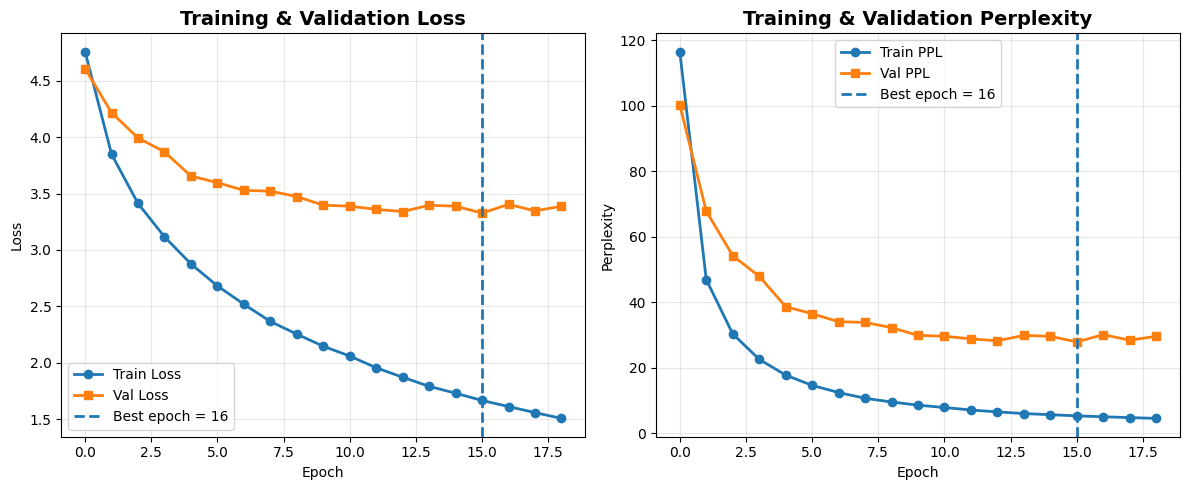

✅ Saved: training_curves.png


In [58]:
print("\n" + "="*80)
print("TÓM TẮT BEST EPOCH (THEO VAL LOSS)")
print("="*80)
# Vẽ đồ thị Train Loss và Validation Loss trong suốt quá trình huấn luyện
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o", linewidth=2)
plt.plot(val_losses, label="Val Loss", marker="s", linewidth=2)
plt.axvline(np.argmin(val_losses), linestyle="--", linewidth=2, label=f"Best epoch = {np.argmin(val_losses) + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

# Perplexity
plt.subplot(1, 2, 2)
train_ppl = [math.exp(x) for x in train_losses]
val_ppl = [math.exp(x) for x in val_losses]
plt.plot(train_ppl, label="Train PPL", marker="o", linewidth=2)
plt.plot(val_ppl, label="Val PPL", marker="s", linewidth=2)
plt.axvline(np.argmin(val_losses), linestyle="--", linewidth=2, label=f"Best epoch = {np.argmin(val_losses) + 1}")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training & Validation Perplexity", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: training_curves.png")

## 10. Đánh giá mô hình trên tập Test

In [59]:
print("\n" + "="*80)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*80)
print("\n" + "="*80)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*80)

checkpoint_path = "best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

test_loss = evaluate(model, test_loader, criterion, device)

print(f"\n🎯 Test Results:")
print(f"  • Test Loss: {test_loss:.3f}")
print(f"  • Test PPL:  {math.exp(test_loss):.3f}")



ĐÁNH GIÁ TRÊN TEST SET

ĐÁNH GIÁ TRÊN TEST SET



🎯 Test Results:
  • Test Loss: 3.200
  • Test PPL:  24.530


## 11. Hàm dịch

In [60]:
print("\n" + "="*80)
print("INFERENCE - HÀM DỊCH")
print("="*80)

def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    model.eval()
    tokens = tokenize_en(sentence) if isinstance(sentence, str) else sentence
    src_ids = src_vocab.numericalize(tokens)
    src_tensor  = torch.LongTensor(src_ids).unsqueeze(0).to(device)
    src_lengths = torch.LongTensor([len(src_ids)]).to(device)
    trg_indexes = [trg_vocab.stoi["<sos>"]]
    with torch.no_grad():
        enc_out = model.encoder(src_tensor, src_lengths, return_outputs=False)
        hidden, cell = enc_out
        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)
            if pred_token == trg_vocab.stoi["<eos>"]:
                break
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1]

@torch.no_grad()
def translate(sentence: str, max_len: int = 50) -> str:
    return " ".join(translate_sentence(model, sentence, en_vocab, fr_vocab, device, max_len=max_len))

print("✅ Translation functions defined!")



INFERENCE - HÀM DỊCH
✅ Translation functions defined!


## 12. Tính BLEU SCORE

In [69]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

def calculate_bleu(pairs, en_vocab, fr_vocab, model, device, max_samples=None, max_len=50):
    # vocab maps
    fr_stoi = fr_vocab.stoi if hasattr(fr_vocab, "stoi") else fr_vocab
    fr_itos = fr_vocab.itos if hasattr(fr_vocab, "itos") else None
    en_stoi = en_vocab.stoi if hasattr(en_vocab, "stoi") else en_vocab
    if fr_itos is None:  # build itos nếu chỉ có stoi
        fr_itos = [None] * (max(fr_stoi.values()) + 1)
        for tok, idx in fr_stoi.items():
            if idx < len(fr_itos):
                fr_itos[idx] = tok

    pad_idx = fr_stoi.get("<pad>", fr_stoi.get("<PAD>", 0))
    sos_idx = fr_stoi.get("<sos>", fr_stoi.get("<SOS>", 1))
    eos_idx = fr_stoi.get("<eos>", fr_stoi.get("<EOS>", 2))
    unk_idx = fr_stoi.get("<unk>", fr_stoi.get("<UNK>", 3))
    smooth = SmoothingFunction().method4

    preds, refs = [], []
    n = len(pairs) if max_samples is None else min(max_samples, len(pairs))

    model.eval()
    with torch.no_grad():
        for src_tokens, trg_tokens in pairs[:n]:
            # chuỗi -> id nếu cần
            src_ids = [en_stoi.get(t, en_stoi.get("<unk>", 3)) for t in src_tokens] if src_tokens and isinstance(src_tokens[0], str) else list(src_tokens)
            trg_ids = [fr_stoi.get(t, unk_idx) for t in trg_tokens] if trg_tokens and isinstance(trg_tokens[0], str) else list(trg_tokens)

            src_tensor = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)
            src_len = torch.tensor([len(src_ids)], dtype=torch.long, device=device)
            hidden, cell = model.encoder(src_tensor, src_len)

            inp = torch.tensor([sos_idx], device=device)
            pred_ids = []
            for _ in range(max_len):
                out, hidden, cell = model.decoder(inp, hidden, cell)
                top1 = out.argmax(1).item()
                if top1 == eos_idx:
                    break
                pred_ids.append(top1)
                inp = torch.tensor([top1], device=device)

            pred_tokens = [fr_itos[i] for i in pred_ids if i not in {pad_idx, sos_idx, eos_idx}]
            ref_tokens = [[fr_itos[i] for i in trg_ids if i not in {pad_idx, sos_idx, eos_idx}]]

            preds.append(pred_tokens)
            refs.append(ref_tokens)

    bleu = corpus_bleu(refs, preds, smoothing_function=smooth) * 100
    return bleu, preds, refs

# Chuẩn bị data test và tính BLEU
test_data = list(zip(test_en, test_fr))
max_samples = 500
test_data_used = test_data[:max_samples]

bleu_score, predictions, references = calculate_bleu(test_data_used, en_vocab, fr_vocab, model, device)
print(f"Overall BLEU: {bleu_score:.2f}")

# BLEU theo độ dài nguồn (ngắn/trung/bd) – dùng tiếp đoạn của bạn
short_bleu, medium_bleu, long_bleu = [], [], []
smooth = SmoothingFunction().method4
for (src_tokens, _), pred, ref in zip(test_data_used, predictions, references):
    bleu = sentence_bleu(ref, pred, smoothing_function=smooth) * 100
    (short_bleu if len(src_tokens) < 10 else medium_bleu if len(src_tokens) <= 20 else long_bleu).append(bleu)

if short_bleu:
    print(f"  • Short (<10 words):   {sum(short_bleu)/len(short_bleu):.2f} ({len(short_bleu)} sentences)")
if medium_bleu:
    print(f"  • Medium (10-20):      {sum(medium_bleu)/len(medium_bleu):.2f} ({len(medium_bleu)} sentences)")
if long_bleu:
    print(f"  • Long (>20 words):    {sum(long_bleu)/len(long_bleu):.2f} ({len(long_bleu)} sentences)")


Overall BLEU: 35.30
  • Short (<10 words):   44.70 (103 sentences)
  • Medium (10-20):      32.62 (384 sentences)
  • Long (>20 words):    20.38 (13 sentences)


## 13. SHOW EXAMPLE TRANSLATIONS

In [ ]:
print("\n" + "="*80)
print("🌐 EXAMPLE TRANSLATIONS")
print("="*80)

sample_indices = random.sample(range(len(predictions)), min(10, len(predictions)))

for idx in sample_indices:
    src_sent = test_en[idx]
    ref_sent = references[idx][0]
    pred_sent = predictions[idx]

    print(f"\n{'─'*80}")
    print(f"🇬🇧 Source:    {' '.join(src_sent)}")
    print(f"🇫🇷 Reference: {' '.join(ref_sent)}")
    print(f"🤖 Predicted:  {' '.join(pred_sent)}")

    correct_words = sum(1 for p, r in zip(pred_sent, ref_sent) if p == r)
    accuracy = correct_words / max(len(ref_sent), 1) * 100

    len_diff = len(pred_sent) - len(ref_sent)

    print(f"📊 Word Accuracy: {accuracy:.1f}% | Length: {len(pred_sent)} vs {len(ref_sent)} ({len_diff:+d})")

print("\n" + "="*80)



🌐 EXAMPLE TRANSLATIONS

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a kid crosscountry skis wearing the number " 93 " .
🇫🇷 Reference: un enfant fait du ski de fond avec le numéro " <unk> " .
🤖 Predicted:  un enfant soude un numéro <unk> " <unk> <unk> <unk> .
📊 Word Accuracy: 14.3% | Length: 11 vs 14 (-3)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    two workers spread cement onto a brick building .
🇫🇷 Reference: deux ouvriers <unk> du ciment sur un bâtiment en briques .
🤖 Predicted:  deux ouvriers installant du ciment sur un bâtiment en briques .
📊 Word Accuracy: 90.9% | Length: 11 vs 11 (+0)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a dog drinks water outside on the grass .
🇫🇷 Reference: un chien boit de l' eau dehors sur l' herbe .
🤖 Predicted:  un chien boit dehors l' eau sur l' herbe .
📊 Word Accuracy: 45.5% | Length: 10 vs 11 (

## 14. Khởi tạo encoder, decoder_with_attention, seq2seq_attention Tạo optimizer + scheduler

In [72]:
print("\n" + "="*80)
print("ATTENTION MECHANISM")
print("="*80)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: [n_layers, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        hidden = hidden[-1]  # Lấy hidden state cuối cùng: [batch_size, hidden_dim]
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Expand hidden để match với encoder_outputs
        hidden_expanded = hidden.unsqueeze(1).expand(-1, src_len, -1)  # [batch_size, src_len, hidden_dim]

        # Tính energy
        energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_dim]
        energy = energy.matmul(self.v.unsqueeze(0).unsqueeze(0).transpose(1, 2))  # [batch_size, src_len, 1]
        energy = energy.squeeze(2)  # [batch_size, src_len]

        # Attention weights
        attention_weights = torch.nn.functional.softmax(energy, dim=1)  # [batch_size, src_len]

        return attention_weights

print("✅ Attention class defined!")



ATTENTION MECHANISM
✅ Attention class defined!


## 15. Huấn luyện Attention Model

In [73]:
print("\n" + "="*80)
print("DECODER VỚI ATTENTION")
print("="*80)

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)  # Hidden + Context
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input: [batch_size]
        # hidden: [n_layers, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # [batch_size, 1, hidden_dim]
        output = output.squeeze(1)  # [batch_size, hidden_dim]

        # Tính attention weights
        attention_weights = self.attention(hidden, encoder_outputs)  # [batch_size, src_len]

        # Tính context vector
        context = attention_weights.unsqueeze(1).bmm(encoder_outputs)  # [batch_size, 1, hidden_dim]
        context = context.squeeze(1)  # [batch_size, hidden_dim]

        # Kết hợp hidden + context
        combined = torch.cat((output, context), dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.fc_out(combined)  # [batch_size, output_dim]

        return prediction, hidden, cell

print("✅ DecoderWithAttention class defined!")



DECODER VỚI ATTENTION
✅ DecoderWithAttention class defined!


## 16. Dịch & Đánh giá Attention

In [74]:
print("\n" + "="*80)
print("SEQ2SEQ VỚI ATTENTION")
print("="*80)

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        # Encoder - yêu cầu encoder_outputs cho attention
        hidden, cell, encoder_outputs = self.encoder(src, src_lengths, return_outputs=True)

        inp = trg[:, 0]  # <sos> token
        for t in range(1, trg_len):
            # Decoder với attention
            out, hidden, cell = self.decoder(inp, hidden, cell, encoder_outputs)
            outputs[:, t, :] = out

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            inp = trg[:, t] if teacher_force else top1

        return outputs


# Khởi tạo Attention Model
print("\n🏗️  Initializing Attention Model...")
decoder_attn = DecoderWithAttention(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model_attn = Seq2SeqWithAttention(encoder, decoder_attn, device).to(device)

print("✅ Attention model initialized!")
print(f"  • Total parameters: {count_parameters(model_attn):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder_attn):,}")

# Optimizer cho attention model
optimizer_attn = optim.Adam(model_attn.parameters(), lr=1e-3)
scheduler_attn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_attn, mode="min", factor=0.5, patience=2
)

print("\n⚙️  Optimizer & Scheduler configured for Attention Model!")



SEQ2SEQ VỚI ATTENTION

🏗️  Initializing Attention Model...
✅ Attention model initialized!
  • Total parameters: 17,678,150
  • Encoder params:   5,186,560
  • Decoder params:   12,491,590

⚙️  Optimizer & Scheduler configured for Attention Model!


## 17. Train (attention)

In [ ]:
print("\n" + "="*80)
print("HUẤN LUYỆN MÔ HÌNH VỚI ATTENTION")
print("="*80)

N_EPOCHS = 20
PATIENCE = 3
best_valid_loss_attn = float("inf")
patience_counter_attn = 0

train_losses_attn, val_losses_attn = [], []

print(f"\n⏰ Training Attention Model for {N_EPOCHS} epochs...")
print(f"📊 Early stopping patience: {PATIENCE}")
print("="*80)

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(
        model_attn, train_loader, optimizer_attn, criterion,
        clip=CLIP, device=device, tf_ratio=TEACHER_FORCING_RATIO
    )

    valid_loss = evaluate(model_attn, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_attn.append(train_loss)
    val_losses_attn.append(valid_loss)

    scheduler_attn.step(valid_loss)

    print(f"\n📅 Epoch: {epoch+1:02}/{N_EPOCHS} | ⏱️  Time: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"   📉 Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}")
    print(f"   📉 Val Loss:   {valid_loss:.3f} | PPL: {math.exp(valid_loss):7.3f}")

    if valid_loss < best_valid_loss_attn:
        best_valid_loss_attn = valid_loss
        patience_counter_attn = 0
        torch.save(model_attn.state_dict(), "best_attention_model.pth")
        print("   ✅ Best attention model saved!")
    else:
        patience_counter_attn += 1
        print(f"   ⏳ Patience: {patience_counter_attn}/{PATIENCE}")

    if patience_counter_attn >= PATIENCE:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

print("\n" + "="*80)
print("✅ Training completed!")



HUẤN LUYỆN MÔ HÌNH VỚI ATTENTION

⏰ Training Attention Model for 20 epochs...
📊 Early stopping patience: 3



📅 Epoch: 01/20 | ⏱️  Time: 1m 12s
   📉 Train Loss: 3.804 | PPL:  44.895
   📉 Val Loss:   3.337 | PPL:  28.137
   ✅ Best attention model saved!



📅 Epoch: 02/20 | ⏱️  Time: 1m 9s
   📉 Train Loss: 2.536 | PPL:  12.633
   📉 Val Loss:   3.109 | PPL:  22.408
   ✅ Best attention model saved!



📅 Epoch: 03/20 | ⏱️  Time: 1m 10s
   📉 Train Loss: 2.127 | PPL:   8.390
   📉 Val Loss:   3.061 | PPL:  21.343
   ✅ Best attention model saved!



📅 Epoch: 04/20 | ⏱️  Time: 1m 9s
   📉 Train Loss: 1.891 | PPL:   6.627
   📉 Val Loss:   2.934 | PPL:  18.802
   ✅ Best attention model saved!



📅 Epoch: 05/20 | ⏱️  Time: 1m 9s
   📉 Train Loss: 1.695 | PPL:   5.446
   📉 Val Loss:   3.014 | PPL:  20.363
   ⏳ Patience: 1/3



📅 Epoch: 06/20 | ⏱️  Time: 1m 10s
   📉 Train Loss: 1.559 | PPL:   4.754
   📉 Val Loss:   3.037 | PPL:  20.847
   ⏳ Patience: 2/3


Training:  67%|██████▋   | 306/454 [00:46<00:20,  7.27it/s]

## so sanh

In [1]:
print("\n" + "="*80)
print("SO SÁNH BLEU: NO-ATTENTION vs ATTENTION")
print("="*80)

MAX_SAMPLES = 500
test_data_full = list(zip(test_en, test_fr))
test_data_used = test_data_full[:MAX_SAMPLES]

def eval_bleu(model_obj, ckpt_path):
    model_obj.load_state_dict(torch.load(ckpt_path, map_location=device))
    model_obj.eval()
    bleu, preds, refs = calculate_bleu(
        test_data_used, en_vocab, fr_vocab, model_obj, device, max_samples=None
    )
    return bleu, len(preds)

base_bleu, base_n = eval_bleu(model, "best_model.pth")
attn_bleu, attn_n = eval_bleu(model_attn, "best_attention_model.pth")

print(f"Baseline (no attention) BLEU: {base_bleu:.2f}   | n={base_n}")
print(f"Attention BLEU:               {attn_bleu:.2f}   | n={attn_n}")
print(f"Δ BLEU (attn - base):         {attn_bleu - base_bleu:+.2f}")



SO SÁNH BLEU: NO-ATTENTION vs ATTENTION


NameError: name 'test_en' is not defined